# 데이터 획득

In [51]:
# 모듈
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report, roc_curve
from scipy import sparse
from xgboost import XGBRFClassifier

%matplotlib inline

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
# id 컬럼은 인덱스 정도 의미
train      = pd.read_csv( '/content/drive/MyDrive/cloud_ai/모듈_프로젝트_2/ep.2/res/train (1).csv', index_col='id' )
test       = pd.read_csv( '/content/drive/MyDrive/cloud_ai/모듈_프로젝트_2/ep.2/res/test (1).csv', index_col='id' )
submission = pd.read_csv( '/content/drive/MyDrive/cloud_ai/모듈_프로젝트_2/ep.2/res/sample_submission (1).csv', index_col='id' )

#데이터 준비 + EDA(분석, 피처 엔지니어링 대상 및 처리내용 체크)

## 데이터 및 결측치 확인

In [54]:
train.head().T

id,0,1,2,3,4
gender,Male,Male,Female,Male,Female
age,28.0,33.0,42.0,56.0,24.0
hypertension,0,0,0,0,0
heart_disease,0,0,0,0,0
ever_married,Yes,Yes,Yes,Yes,No
work_type,Private,Private,Private,Private,Private
Residence_type,Urban,Rural,Rural,Urban,Rural
avg_glucose_level,79.53,78.44,103.0,64.87,73.36
bmi,31.1,23.9,40.3,28.8,28.8
smoking_status,never smoked,formerly smoked,Unknown,never smoked,never smoked


- 데이터 확인 내용




```

'gender', : Male, Female, other로 구성됨 
            - other의 개수 1개로 확인됨
'age', : 나이 /  수치형
'hypertension',  : 고혈압 유무 / 0 : 무, 1 : 유 => 이진형
'heart_disease', : 심장질환 유무 / 0 : 무, 1 : 유 => 이진형
'ever_married', : 결혼 유무 / Y : 기혼, N : 미혼 => 이진형
'work_type', : 업무형태 / 'Private', 'children', 'Govt_job', 'Self-employed', 'Never_worked' => 명목형
'Residence_type', : 거지 /  Urban, Rural / 도시, 시골 => 이진형
'avg_glucose_level', 평균 당 수치 / 수치형 
'bmi', : 비만도 / 수치형
'smoking_status', : 흡연상태  / 'never smoked', 'formerly smoked', 'Unknown', 'smokes' => 명목형
'stroke' : 뇌졸중 유무 / 0 : 무, 1 : 유  => 정답
```






In [55]:
# 고유값 갯수 확인
train.nunique().values, test.nunique().values, submission.nunique().values

(array([   3,  106,    2,    2,    2,    5,    2, 3740,  407,    4,    2]),
 array([   3,  106,    2,    2,    2,    5,    2, 3265,  400,    4]),
 array([1]))

In [56]:
# train, test, submission 인덱스 확인
train.columns, test.columns, submission.columns

(Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
        'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
        'smoking_status', 'stroke'],
       dtype='object'),
 Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
        'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
        'smoking_status'],
       dtype='object'),
 Index(['stroke'], dtype='object'))

In [57]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15304 entries, 0 to 15303
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             15304 non-null  object 
 1   age                15304 non-null  float64
 2   hypertension       15304 non-null  int64  
 3   heart_disease      15304 non-null  int64  
 4   ever_married       15304 non-null  object 
 5   work_type          15304 non-null  object 
 6   Residence_type     15304 non-null  object 
 7   avg_glucose_level  15304 non-null  float64
 8   bmi                15304 non-null  float64
 9   smoking_status     15304 non-null  object 
 10  stroke             15304 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 1.4+ MB


In [58]:
# 결측치 없음
train.isnull().sum().values, test.isnull().sum().values,submission.isnull().sum().values

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0]))

In [59]:
test.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
id,,,,,,,,,,
15304,Female,57.0,0,0,Yes,Private,Rural,82.54,33.4,Unknown
15305,Male,70.0,1,0,Yes,Private,Urban,72.06,28.5,Unknown
15306,Female,5.0,0,0,No,children,Urban,103.72,19.5,Unknown
15307,Female,56.0,0,0,Yes,Govt_job,Urban,69.24,41.4,smokes
15308,Male,32.0,0,0,Yes,Private,Rural,111.15,30.1,smokes


In [60]:
submission.head()

,stroke
id,
15304,0.041296
15305,0.041296
15306,0.041296
15307,0.041296
15308,0.041296


In [61]:
# test.id = submission id 
train.shape, test.shape, submission.shape

((15304, 11), (10204, 10), (10204, 1))

- test, submission의 id 동일함
- 정답인 stroke는 test 데이터에는 없음 / train, submission에만 존재함

## 시각화를 통한 정답값 분포 확인

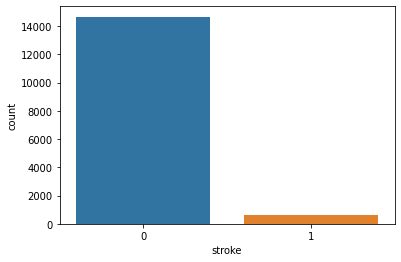

In [62]:
# stroke 값 확인
# 뇌졸중를 가진 사람보다 뇌졸중이 아닌 사람이 많음 
sns.countplot(data=train, x='stroke');

In [63]:
c0, c1 = np.unique( train.stroke.values, return_counts=True)[1]
c0 / c1 
# 0이 1보다 23.21518987341772배 많음 => 뇌졸중 환자보다 뇌졸중 환자가 아닌 사람이 23.21518987341772배 많음

23.21518987341772

타겟값간 비율 23.21518987341772


Text(0.5, 1.0, 'Stroke Value Distribution')

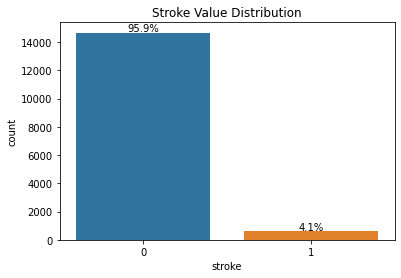

In [64]:
# 향후 시각화 자료에 비율을 표기하는 부분을 추가 => 텍스트 드로잉
def show_text_percent_by_stroke( ax, total_count, is_show=True,  ):
  '''
    is_show : True일때만 텍스트가 노출되게 처리
    ax : 텍스트를 그리고자 하는 차트의 축정보
    total_count : 전체 카운트수
  '''
  persents = list()         # 비율을 담는 그릇
  # 카운트 플롯 차트상에 개별 박스 정보를 구하는 방법 -> ax.patches

  # 카운트 플롯 차트상에서 순차적으로 박스를 하나씩 추출한다
  for patch in ax.patches: # 차트상에 존재하는 모든 형태의 도형을 차례대로 추출하는 연속형 변수
    w = patch.get_width()  # 타겟값 0 혹은 1, 카운트 플롯의 개별 박스 너비
    h = patch.get_height() # 타겟값 0 혹은 1의 카운트수 -> 카운트 플롯의 개별 박스 높이->카운트
    p = h/total_count * 100 # 타깃값의 비율 = (개별박스의 높이(카운트) / 전체카운트)*100
    persents.append( p )
    # 텍스트 그리기
    # 좌표 정보 획득
    l = patch.get_x()    # 도형 왼쪽 테투리 X축의 기준 위치값    
    ax.text(  x=l + w/2,  # 도형의 정 가운데를 X축 좌표
              y=h + total_count*0.005, # 1, total_count(가변값)의 특정 비율로 올려서 위치를 조정
              s=f'{p:1.1f}%', # 타겟값의 비율을 개별 차트내 도형 위에 그려지는 내용 ex) 38.8% /  현 차트 내에 69.4%, 30.6% 임
              ha='center'    # 정렬(가운데)
            )
  if is_show:
    if len(persents) == 2: # 타겟용
      print( '타겟값간 비율', persents[0]/persents[1] )
    elif len(persents) == 4: # 이진 피처용
      # print(persents)
      # 타겟값에 맞춰서 도형이 그려진다 0번 타겟이 먼저 그려지고, 1번 타겟이 나중에 그려진다
      print( persents[0]/persents[2], persents[1]/persents[3] )
  pass

ax = sns.countplot( data=train, x='stroke');
show_text_percent_by_stroke( ax, train.shape[0] )
ax.set_title('Stroke Value Distribution')

- 정답 값 중 0(뇌졸중 무) : 95.9% 를 차지하고 있음
- 정답 값 중 0(뇌졸중 유) : 4.1% 를 차지하고 있음

##데이터 분석

- 수치형
  - age
  - avg_glucose_level
  -bmi
- 명목형
  - 이진형
    - hypertension
    - heart_disease
    - Residence_type
    - ever_married
  - 고유값 2개 초과
    - gender
    - work_type
    - smoking_status

In [65]:
# 수치형, 명목형, 명목형 하 이진형 및 이외 항목으로 세분화해서 지정해둠
# 수치형
num_cols = ['age', 'avg_glucose_level', 'bmi'] 
# 명목형
cat_cols = ['gender', 'hypertension','heart_disease', 'Residence_type', 'work_type', 'smoking_status'] 
# 명목형을 고유값 개수에 따라 세부 분류함
cat_cols_v0 = ['gender'] # gender만 따로 진행한 이유는 male, female, other로 고유값 3개로 확인되어 따로 지정해둠 
cat_cols_v1 = ['hypertension','heart_disease', 'Residence_type', 'ever_married']
cat_cols_v2 = ['work_type', 'smoking_status']

In [66]:
train.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

### 수치형

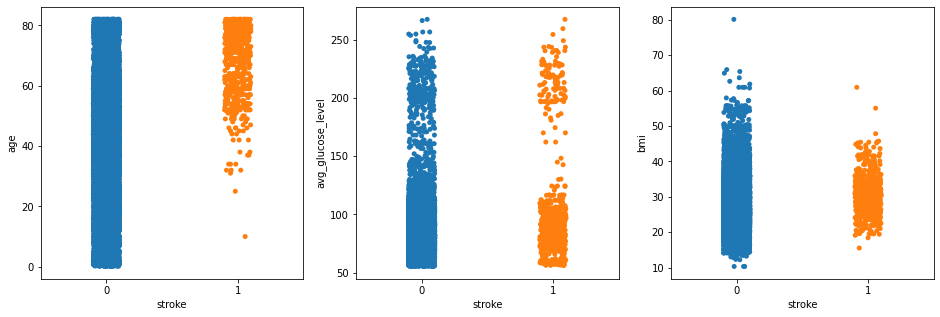

In [67]:
# 수치형 
plt.figure(figsize=(16, 5))
plt.subplot(1, 3,1)
sns.stripplot(data=train, x='stroke', y='age' )
plt.subplot(1, 3,2)
sns.stripplot(data=train, x='stroke', y='avg_glucose_level')
plt.subplot(1, 3,3)
sns.stripplot(data=train, x='stroke', y='bmi')

- 나이 :뇌졸중 환자 중  40~60대 많음
- 평균 당수치 : 뇌졸중 환자 중 당 수치가 높은 사람보다 낮은 사람이 많다 => 당수치와의 상관관계는 적은 것으로 예상됨
- bmi : 뇌졸중 환자의 bmi 수치는 약 20 ~ 40에 분포되어 있으나 뇌졸중 환자가 아닌 사람 또한 비슷한 구간에 분표되어 있어 변별력은 없을 것이라고 예상됨

### 명목형

- 이진형
  - hypertension
  - heart_disease
  - Residence_type
  - ever_married
- 고유값 2개 초과
  - gender
  - work_type
  - smoking_status

### 고유값 2개 이상

In [68]:
train['gender'].unique()
# 'Male', 'Female', 'Other' 존재함

array(['Male', 'Female', 'Other'], dtype=object)

In [69]:
train['gender'].value_counts()
# 'other'이 1개 존재함

Female    9446
Male      5857
Other        1
Name: gender, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


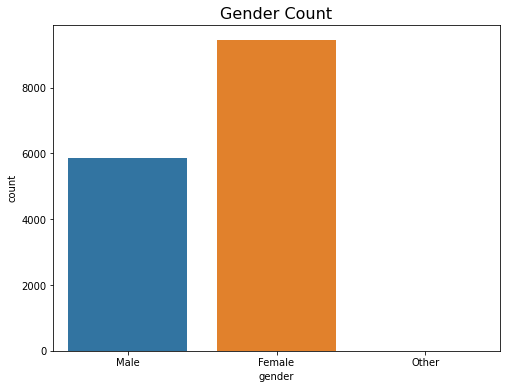

In [70]:
# gender의 개수 시각화 
# 데이터 중 남성보다 여성이 높다 
plt.figure(figsize=(8, 6))

ax = sns.countplot(train['gender'])
ax.set_title('Gender Count', fontdict={'fontsize': 16})
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


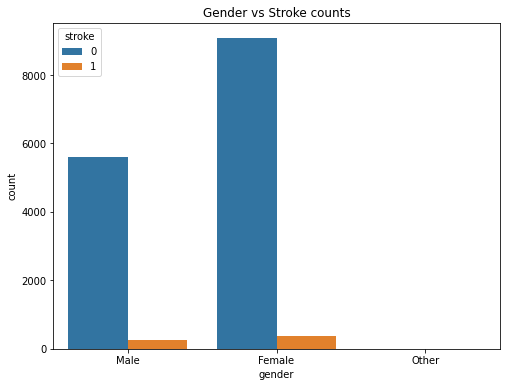

In [71]:
# gender별 뇌졸중 유무 시각화 
plt.figure(figsize=(8, 6))
ax = sns.countplot(train['gender'], hue=train['stroke'])
ax.set_title('Gender vs Stroke counts')
plt.show()

In [72]:
# gender 교차분석표 작성
def make_cross_tab(df, id ):
  cross_tab = pd.crosstab( df[id], df['stroke'], normalize='index' ) *100
  cross_tab.reset_index(inplace=True)
  return cross_tab

cross_tab_v1 = make_cross_tab(train, 'gender') 
cross_tab_v1

stroke,gender,0,1
0,Female,96.104171,3.895829
1,Male,95.492573,4.507427
2,Other,100.000000,0.000000


- Female 중 약 3.89%, Male 중 약 4.50%가 뇌졸중 환자로 확인됨
- other은 1명 존재하며 뇌졸중 환자가 아님

In [73]:
# work_type 고유값 확인
train['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [74]:
# work_type 고유값별 개수 확인
train['work_type'].value_counts()

Private          9752
children         2038
Self-employed    1939
Govt_job         1533
Never_worked       42
Name: work_type, dtype: int64

In [75]:
# work_type 교차분석표
cross_tab_v2 = make_cross_tab(train, 'work_type') 
cross_tab_v2

stroke,work_type,0,1
0,Govt_job,95.499022,4.500978
1,Never_worked,100.000000,0.000000
2,Private,95.857260,4.142740
3,Self-employed,91.851470,8.148530
4,children,99.950932,0.049068


In [76]:
# smoking_status 고유값 확인
train['smoking_status'].unique()

array(['never smoked', 'formerly smoked', 'Unknown', 'smokes'],
      dtype=object)

In [77]:
# smoking_status 고유값별 개수 확인
train['smoking_status'].value_counts()

never smoked       6281
Unknown            4543
formerly smoked    2337
smokes             2143
Name: smoking_status, dtype: int64

In [78]:
# smoking_status 교차분석표
cross_tab_v3 = make_cross_tab(train, 'smoking_status') 
cross_tab_v3

stroke,smoking_status,0,1
0,Unknown,97.622716,2.377284
1,formerly smoked,93.196406,6.803594
2,never smoked,95.908295,4.091705
3,smokes,94.960336,5.039664


In [79]:
# cat_cols_v2 = ['work_type', 'smoking_status']
def show_pointplot(id,cross_tab, color, ax=None):
  if ax:
    sns.pointplot( x= id ,            # 피처값
                  y= 1,            # 정답 1에 대한 포인트 플롯
                  data=cross_tab,  # 그리는 대상 df 
                  order= cross_tab[id],          # 포인트 플롯 순서 
                  color=color,     # 그리는 색상
                  ax=ax
                  );
show_pointplot_v2 = show_pointplot('work_type', cross_tab_v2, 'blue')
show_pointplot_v3 = show_pointplot('smoking_status', cross_tab_v2, 'blue')
# nom_0에 설정된 사용하는 고유값 별로 1의 비율이 다르다 -> 구분된다 -> 학습에 도움된다 

0.723292469352014 1.0905272981801213


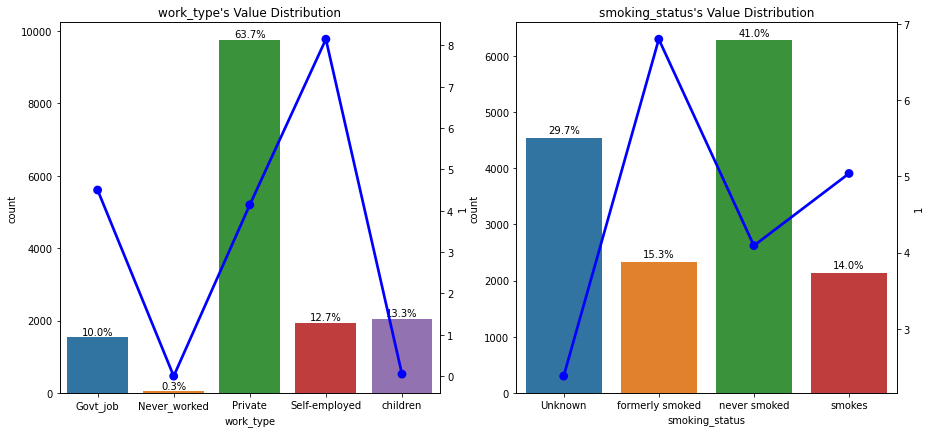

In [80]:
# cat_cols_v2 = ['work_type', 'smoking_status']
def show_count_point_plot( all_data, features, rows=2, cols=2): 
  # 1개의 차트에 격자로 분할 -> 각 자리에 ax를 전달 -> 이것을 이용하여 그린다 
  plt.figure( figsize=(15,15) ) # 그리면서 조정 : 세로 3칸, 가로 2칸
  # 서브플롯 배치 
  p_grid = gridspec.GridSpec(rows, cols) # 3줄, 2칸 => 차트 5개 ;=> 피처가 5개

  for idx, feature in enumerate( features ):
    ax = plt.subplot(p_grid[idx])
    cross_tab = make_cross_tab(all_data, feature )
      # order를 사용했으면 한 차트에 사용되는 모든 함수는 같은 순서(order) 유지해야 동일하게 배치됨(그렇지 않으면 배치가 달라질 수 있다)
    sns.countplot( data=all_data, x=feature, ax=ax, order=cross_tab[feature] ) # ax=ax : 격자 안에서 특정 위치로 차트가 세팅
    show_text_percent_by_stroke( ax, all_data.shape[0] )
    ax.set_title(f'{feature}\'s Value Distribution')

    
    show_pointplot(feature, cross_tab, 'blue', ax.twinx())

  plt.show()

show_count_point_plot( train, cat_cols_v2)

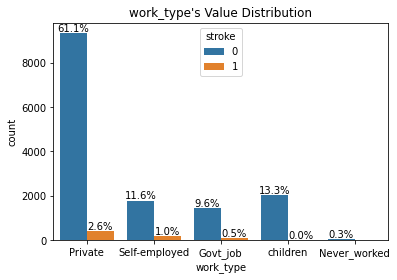

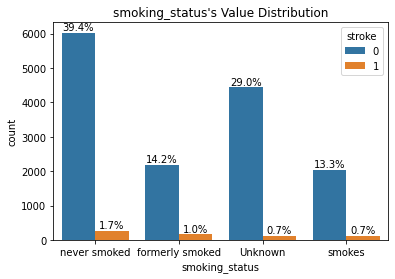

In [81]:
cat_cols_v2 = ['work_type', 'smoking_status']
for cat_col_v2 in cat_cols_v2:
  ax = sns.countplot( data=train, x=cat_col_v2, hue='stroke');
  show_text_percent_by_stroke( ax, train.shape[0] )
  ax.set_title(f'{cat_col_v2}\'s Value Distribution')
  plt.show()

- 업무 : 총 데이터의 직업 중 가장 많은 비중을 차지하고 있는 직업은 Private work_type이나 뇌졸중 환자가 가장 많은 직업은 Self-employed 
=> 발병 순위는 Self-employed - Govt_job - Private_work_type - Never_worked - children 
- 흡연 : 총 데이터 중 담배를 전혀 피지 않았던 사람의 비율이 높음. 뇌졸중 환자가 가장 많은 흡연 상태는 전에 폈음의 비율이 가장 높다 
=> 발병 순위는 fermerly smoked - smokes - never smoked - Unknown

### 이진형

27.855158730158724 4.945312500000001


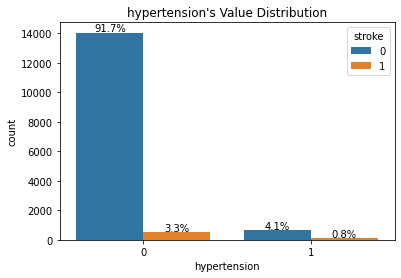

25.40812720848057 4.409090909090908


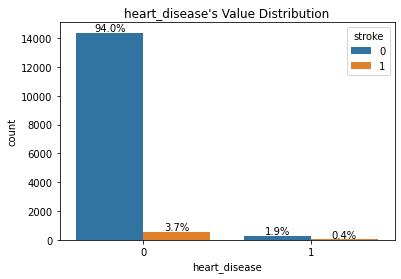

23.253968253968253 23.176656151419557


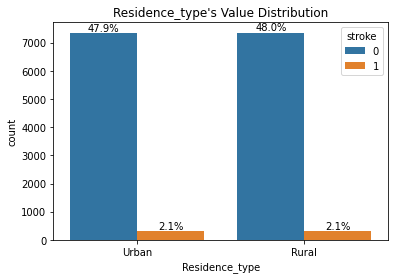

16.57191201353638 118.97560975609757


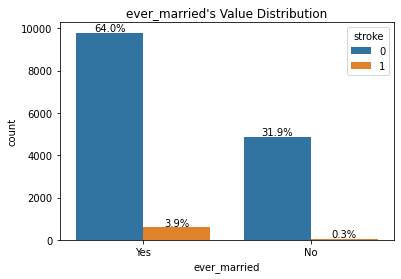

In [82]:
# 이진형 데이터별 
for cat_col_v1 in cat_cols_v1:
  ax = sns.countplot( data=train, x=cat_col_v1, hue='stroke');
  show_text_percent_by_stroke( ax, train.shape[0] )
  ax.set_title(f'{cat_col_v1}\'s Value Distribution')
  plt.show()
  
# 고혈압 : 뇌졸중 환자 중 고혈압 환자의 비율은 낮음 
# 심장질환 : 뇌졸중 환자 중 심장질환 환자의 비율은 낮음
# 거주지역 : 도시, 시골 비율 거의 동일함 => 해당 부분으로는 변별력이 없을 것이라고 예상됨 
# 결혼 : 결혼한 사람들의 비율이 높으며 뇌졸중 환자 중 기혼의 비율이 높음

- 데이터 중 Residence_type과 bmi의 경우 뇌졸중 환자가 아닌 사람과 뇌졸중 환자인 사람들의 분포가 비슷하게 나와서 해당 데이터로는 상관관계를 분석하기에는 무리가 있다고 판단됨

In [83]:
# 'Residence_type', 'bmi' 삭제 => 변별력 무 
train.drop(['Residence_type', 'bmi'], axis=1, inplace=True)
test.drop(['Residence_type', 'bmi'], axis=1, inplace=True)

### 명목형 데이터 중 문자열로 되어 있는 데이터 수치형으로 변환

In [84]:
# train 파일
# gender
train['gender'] = train['gender'].map({
    'Male': 0,
    'Female': 1,
    'Other': 2
}).astype('int')

# ever_married
train['ever_married'] = train['ever_married'].map({
    'Yes': 1,
    'No': 0
}).astype('int')

# work_type
train['work_type'] = train['work_type'].map({
    'Private':0,
    'Self-employed': 1,
    'Govt_job': 2,
    'children': 3,
    'Never_worked': 4
}).astype('int')

# smoking_status
train['smoking_status'] = train['smoking_status'].map({
    'never smoked' : 0,
    'formerly smoked': 1,
    'smokes': 2,
    'Unknown': 3
}).astype('int')

In [85]:
# test 파일
# gender
test['gender'] = test['gender'].map({
    'Male': 0,
    'Female': 1,
    'Other': 2
}).astype('int')

# ever_married
test['ever_married'] = test['ever_married'].map({
    'Yes': 1,
    'No': 0
}).astype('int')

# work_type
test['work_type'] = test['work_type'].map({
    'Private':0,
    'Self-employed': 1,
    'Govt_job': 2,
    'children': 3,
    'Never_worked': 4
}).astype('int')

# smoking_status
test['smoking_status'] = test['smoking_status'].map({
    'never smoked' : 0,
    'formerly smoked': 1,
    'smokes': 2,
    'Unknown': 3
}).astype('int')

In [86]:
# 데이터 변환 후, 타입 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15304 entries, 0 to 15303
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             15304 non-null  int64  
 1   age                15304 non-null  float64
 2   hypertension       15304 non-null  int64  
 3   heart_disease      15304 non-null  int64  
 4   ever_married       15304 non-null  int64  
 5   work_type          15304 non-null  int64  
 6   avg_glucose_level  15304 non-null  float64
 7   smoking_status     15304 non-null  int64  
 8   stroke             15304 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 1.7 MB


In [87]:
# 데이터 변환 후, 타입 확인
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10204 entries, 15304 to 25507
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             10204 non-null  int64  
 1   age                10204 non-null  float64
 2   hypertension       10204 non-null  int64  
 3   heart_disease      10204 non-null  int64  
 4   ever_married       10204 non-null  int64  
 5   work_type          10204 non-null  int64  
 6   avg_glucose_level  10204 non-null  float64
 7   smoking_status     10204 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 717.5 KB


### 인코딩

In [88]:
# 고유값 6개 이상 무 => 원핫인코딩 진행
# 'Residence_type 항목은 삭제했으므로 cat_cols에서 해당 항목을 삭제한 cat_cols1 생성함
cat_cols1 = ['gender', 'hypertension','heart_disease', 'work_type', 'smoking_status']  
cat_one_hot_feats = cat_cols1
print(cat_one_hot_feats)

# train, test 모두 인코딩 진행
enc_cat_train = OneHotEncoder().fit_transform( train[cat_one_hot_feats] )
enc_cat_test = OneHotEncoder().fit_transform( test[cat_one_hot_feats] )
enc_cat_train, enc_cat_test

['gender', 'hypertension', 'heart_disease', 'work_type', 'smoking_status']


(<15304x16 sparse matrix of type '<class 'numpy.float64'>'
 	with 76520 stored elements in Compressed Sparse Row format>,
 <10204x16 sparse matrix of type '<class 'numpy.float64'>'
 	with 51020 stored elements in Compressed Sparse Row format>)

In [89]:
# 데이터 분리
X=train.drop(['stroke'],axis=1)
y=train['stroke']

X.shape, y.shape

((15304, 8), (15304,))

# 피처 스케일링

In [90]:
train.head().T

id,0,1,2,3,4
gender,0.00,0.00,1.0,0.00,1.00
age,28.00,33.00,42.0,56.00,24.00
hypertension,0.00,0.00,0.0,0.00,0.00
heart_disease,0.00,0.00,0.0,0.00,0.00
ever_married,1.00,1.00,1.0,1.00,0.00
work_type,0.00,0.00,0.0,0.00,0.00
avg_glucose_level,79.53,78.44,103.0,64.87,73.36
smoking_status,0.00,1.00,3.0,0.00,0.00
stroke,0.00,0.00,0.0,0.00,0.00


In [91]:
# 수치형 데이터 age와 avg_glucose_level 정규화 => train 파일
minmax = MinMaxScaler()
train[['age', 'avg_glucose_level']] = minmax.fit_transform(train[['age', 'avg_glucose_level']])
train.head(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,smoking_status,stroke
id,,,,,,,,,
0,0,0.340820,0,0,1,0,0.114465,0,0
1,0,0.401855,0,0,1,0,0.109332,1,0
2,1,0.511719,0,0,1,0,0.224974,3,0
3,0,0.682617,0,0,1,0,0.045437,0,0
4,1,0.291992,0,0,0,0,0.085413,0,0


In [92]:
# 수치형 데이터 age와 avg_glucose_level 정규화 => test 파일
minmax = MinMaxScaler()
test[['age', 'avg_glucose_level']] = minmax.fit_transform(test[['age', 'avg_glucose_level']])
test.head(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,smoking_status
id,,,,,,,,
15304,1,0.694824,0,0,1,0,0.129047,3
15305,0,0.853516,1,0,1,0,0.079725,3
15306,1,0.060059,0,0,0,3,0.228727,3
15307,1,0.682617,0,0,1,2,0.066453,2
15308,0,0.389648,0,0,1,0,0.263695,2


In [93]:
# 이진형 데이터 중 문자형 -> 숫자형으로 변환
enc_col = ["gender", "work_type",'ever_married',"smoking_status"]
ord_enc = OrdinalEncoder()
train[enc_col] = ord_enc.fit_transform( train[enc_col] )
test[enc_col] = ord_enc.fit_transform( test[enc_col] )

In [94]:
clf = XGBRFClassifier(n_estimators=1000)
clf.fit(X, y)

XGBRFClassifier(n_estimators=1000)

In [95]:
preds = clf.predict_proba(test)[:, 1]

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11478, 8), (3826, 8), (11478,), (3826,))

In [101]:
# 상관관계 확인
corr_values = train.corr()
corr_values

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,smoking_status,stroke
gender,1.000000,0.032604,-0.005445,-0.061793,0.039360,-0.081464,-0.035468,-0.098927,-0.014974
age,0.032604,1.000000,0.232629,0.193394,0.716964,-0.436211,0.108897,-0.320792,0.261320
hypertension,-0.005445,0.232629,1.000000,0.074178,0.128471,-0.045951,0.122834,-0.086330,0.145895
heart_disease,-0.061793,0.193394,0.074178,1.000000,0.088752,-0.034131,0.137147,-0.027242,0.111518
ever_married,0.039360,0.716964,0.128471,0.088752,1.000000,-0.405407,0.062988,-0.282847,0.114010
work_type,-0.081464,-0.436211,-0.045951,-0.034131,-0.405407,1.000000,-0.023510,0.347019,-0.049566
avg_glucose_level,-0.035468,0.108897,0.122834,0.137147,0.062988,-0.023510,1.000000,-0.012704,0.149273
smoking_status,-0.098927,-0.320792,-0.086330,-0.027242,-0.282847,0.347019,-0.012704,1.000000,-0.035289
stroke,-0.014974,0.261320,0.145895,0.111518,0.114010,-0.049566,0.149273,-0.035289,1.000000


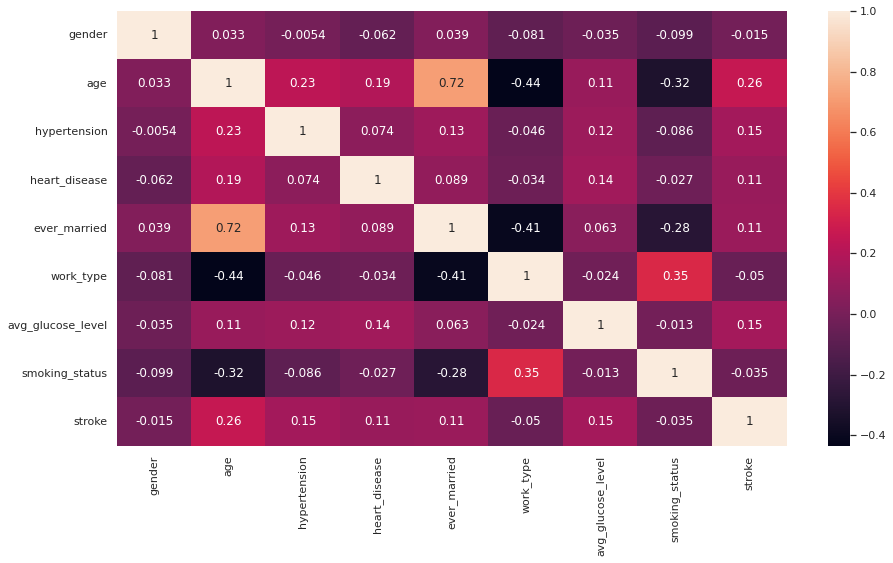

In [102]:
# 히트맵
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(corr_values, annot=True)

In [103]:
clf = LogisticRegression(solver="liblinear").fit(X_train,y_train)

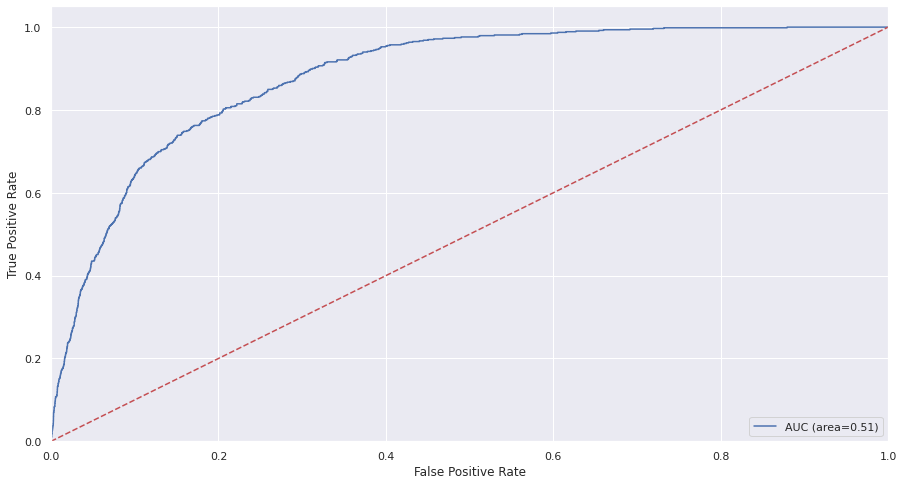

In [104]:
roc_auc=roc_auc_score(y,clf.predict(X))
fpr,tpr,thresholds = roc_curve(y,clf.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr,tpr,label="AUC (area=%0.2f)"%roc_auc)
plt.plot([0,1],[0,1],"r--")
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [105]:
clf.score(X_test,y_test)

0.9584422373235756

In [107]:
print(clf.score(X_train_minmax, y_train))
print(clf.score(X_test_minmax, y_test))

NameError: ignored

# 예측

In [108]:
preds = clf.predict_proba(test)[:, 1]
preds

array([0.00022113, 0.00047486, 0.00019793, ..., 0.00019754, 0.00021656,
       0.00019719])

In [109]:
preds = minmax.fit_transform(preds.reshape(-1, 1))

# 결과

In [110]:
submission = pd.DataFrame({
    'id': np.arange(15304, 25508),
    'stroke': preds.reshape(-1, )
})
submission.head()

,id,stroke
0,15304,0.184397
1,15305,0.613427
2,15306,0.145170
3,15307,0.069616
4,15308,0.223976


In [ ]:
submission.to_csv('submission_ver2.csv', index=False )